#### Company Description
Tasty Bytes is a recipes website. They charges montly subscription to put a full meal plan for families.

#### Company Goal
- Predict which recipes will lead to high traffic in their website when shown at the home page.
- Wants to predict which recipe will be popular 80%, preventing to show unpopular recipes at their website.

#### Data Validation
This data contains 947 rows, 8 columns. The following description of the data was given me:
- **recipe**: Numeric, unique identifier of recipe.
- **calories**: Numeric, number of calories.
- **carbohydrate**: Numeric, amount of carbohydrates in grams.
- **sugar**: Numeric, amount of sugar in grams.
- **protein**: Numeric, amount of protein in grams.
- **category**: Character, type of recipe. Recipes are listed in one of ten possible groupings (Lunch/Snacks, Beverages, Potato, Vegetable, Meat, Chicken, Pork, Dessert, Breakfast, One Dish Meal).
- **servings**: Numeric, number of servings for the recipe.
- **high_traffic**: Character, if the traffic to the site was high when this recipe was shown, this is market with "High".

#### Data Problem
Since we want to predict when the website will have a high traffic or not and was given us the variable **high_traffic** containing only two values, we are facing a **classification problem**. I will build a model that can predict when this variable will be positive or not.

#### Data Changes
- The columns in respect to nutrients: **calories**, **carbohydrate**, **sugar**, and **protein** was with about 5% of total observations as missing values. I dropped these rows.
- The **category** column was with one more category than expected. I replaced all Chicken Breast values to Chicken.
- The **servings** column was with the wrong data type due some text following the number of servings. I removed these text and converted the column to integer.
- The **high_traffic** was full of missing values. Since this is a binary column, I transformed to 1: High trafic and 0: Not High Trafic.


In [154]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [155]:
data = pd.read_csv('Data/recipe_site_traffic_2212.csv')
data

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [157]:
#Check for negative values in data
data.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


In [158]:
#Check for missing values
#Check for nutrient columns
nutrient_cols = ['calories', 'carbohydrate', 'sugar', 'protein']
missing_data = data[data[nutrient_cols].isna().all(axis=1)]
print('Number of remaing rows when dropping rows where all nutrients are missing: ',
       len(data)-len(missing_data))
data.dropna(subset=nutrient_cols, inplace=True)

Number of remaing rows when dropping rows where all nutrients are missing:  895


In [159]:
#Check for category
print(data['category'].nunique())
print(data['category'].unique())
data['category'] = data['category'].str.replace('Chicken Breast', 'Chicken')
print(data['category'].nunique())
print(data['category'].unique())

11
['Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Pork' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
10
['Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken' 'Lunch/Snacks'
 'Pork' 'Vegetable' 'Meat' 'Dessert']


In [160]:
#Check for servings
print(data['servings'].unique())
data['servings'] = data['servings'].str.replace(r'\D+', '', regex=True)
data['servings'] = data['servings'].astype('int')
print(data['servings'].unique())

['4' '1' '2' '6' '4 as a snack' '6 as a snack']
[4 1 2 6]


In [161]:
#Check for High Traffic
print(data['high_traffic'].unique())
data['high_traffic'] = np.where(data['high_traffic']=='High', 1, 0)
print(data['high_traffic'].unique())

['High' nan]
[1 0]


#### Exploratory Analysis

I have explored the target variable and features of the recipes, and the relationship between target variable and features. After exploring the target variable, I noticed that we have more High category for Traffic Distribution. To ensure that the model predicts well both categories, I will stratify by the target variable when spliting the data.


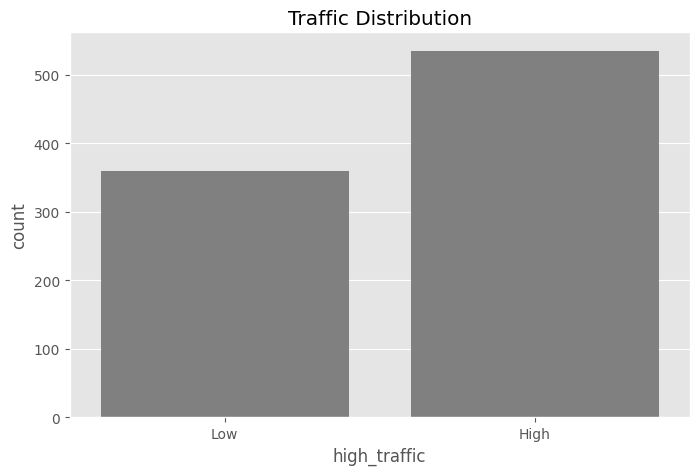

In [162]:
plt.figure(figsize=(8, 5))
sns.countplot(x=data['high_traffic'], color='gray').set(title='Traffic Distribution')
plt.xticks(ticks=[0, 1], labels=['Low', 'High'])
plt.show()

#### Exploring the categorical features
##### Category analysis 
- The data is very balanced between **category**, except for the "Chicken" category that has almost the double of samples.
- When analysing the relationship between these features, **category** and **servings**, and the target feature, **high traffic**; I notice that 'Vegetable', 'Potato' and 'Pork' meals are more likely to bring a High traffic. On the other side, 'Beverages', 'Breakfast', and 'Chicken' are unlikely to bring a High traffic.
- For further investigation, we can increase the number of recipes that are more likely to bring a high traffic and reduce the others that are more unlikely.
##### Servings analysis 
- For **servings**, the most frequent is four per recipe.
- We have a sligth advantage to bring a High Traffic on four serving recipes.
- We should continue to focus on recipes with 4 servings. 


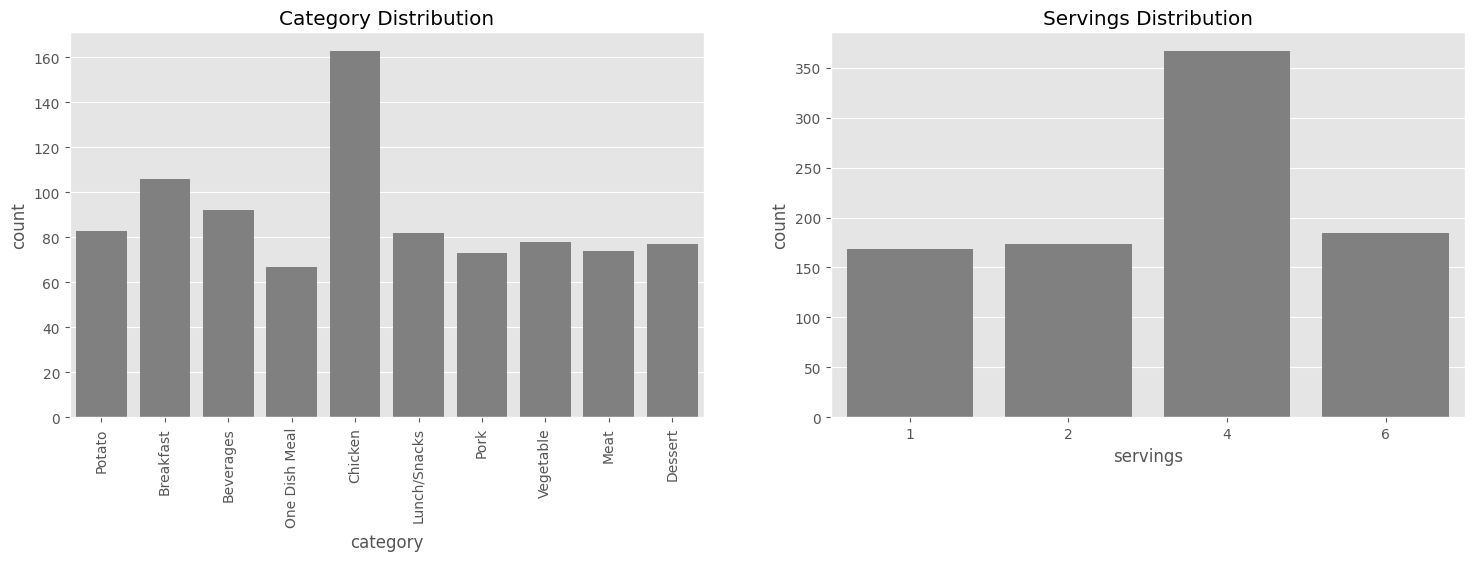

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.countplot(x=data['category'], color='gray', ax=axes[0]).set(title='Category Distribution')
sns.countplot(x=data['servings'], color='gray', ax=axes[1]).set(title='Servings Distribution')
axes[0].tick_params(axis='x', rotation=90)
plt.show()

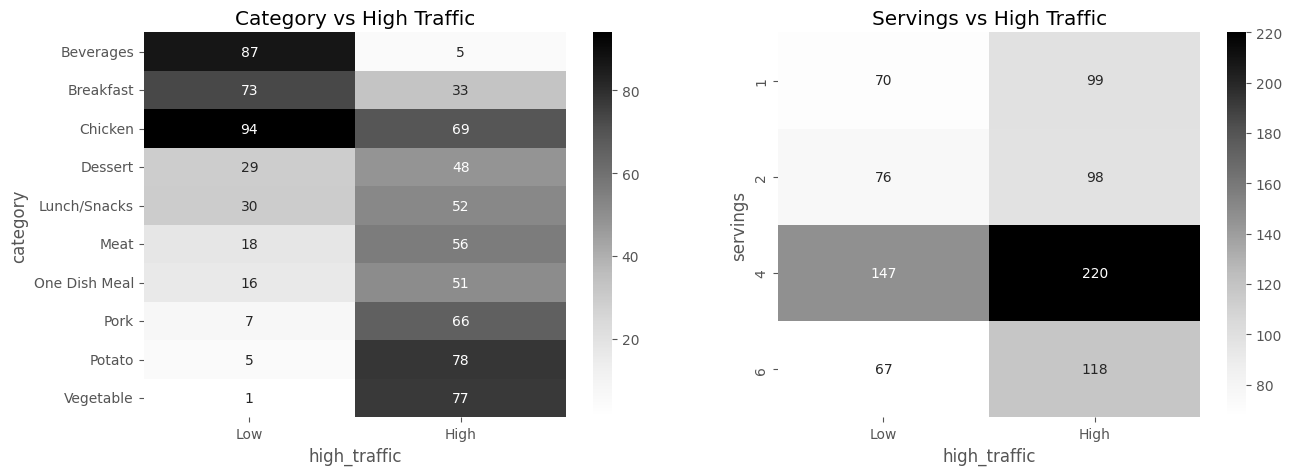

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(pd.crosstab(data['category'], data['high_traffic']), annot=True, cmap='Greys', fmt='d', ax=axes[0]).set(
    title='Category vs High Traffic'
)
sns.heatmap(pd.crosstab(data['servings'], data['high_traffic']), annot=True, cmap='Greys', fmt='d', ax=axes[1]).set(
    title='Servings vs High Traffic'
)
for ax in fig.axes:
    if (fig.axes.index(ax) >= 2):
        break
    ax.set_xticks(ticks=[0.5, 1.5], labels=['Low', 'High'])
plt.show()

#### Exploring the numerical features

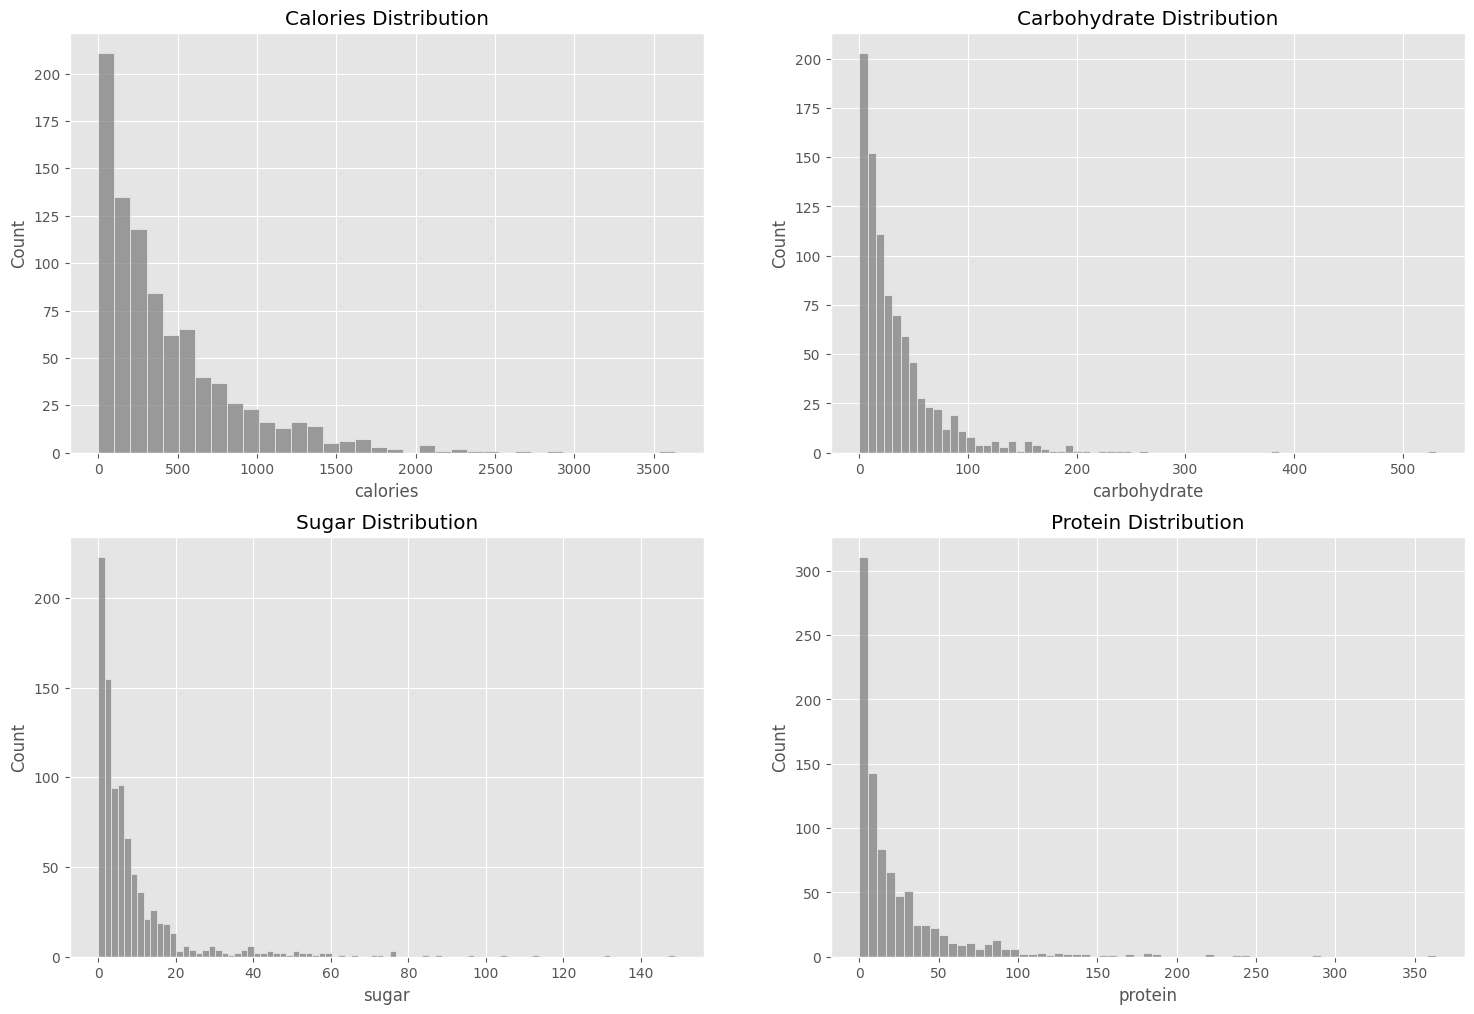

In [165]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
sns.histplot(x=data['calories'], color='gray', ax=axes[0, 0]).set(title='Calories Distribution')
sns.histplot(x=data['carbohydrate'], color='gray', ax=axes[0, 1]).set(title='Carbohydrate Distribution')
sns.histplot(x=data['sugar'], color='gray', ax=axes[1, 0]).set(title='Sugar Distribution')
sns.histplot(x=data['protein'], color='gray', ax=axes[1, 1]).set(title='Protein Distribution')
plt.show()

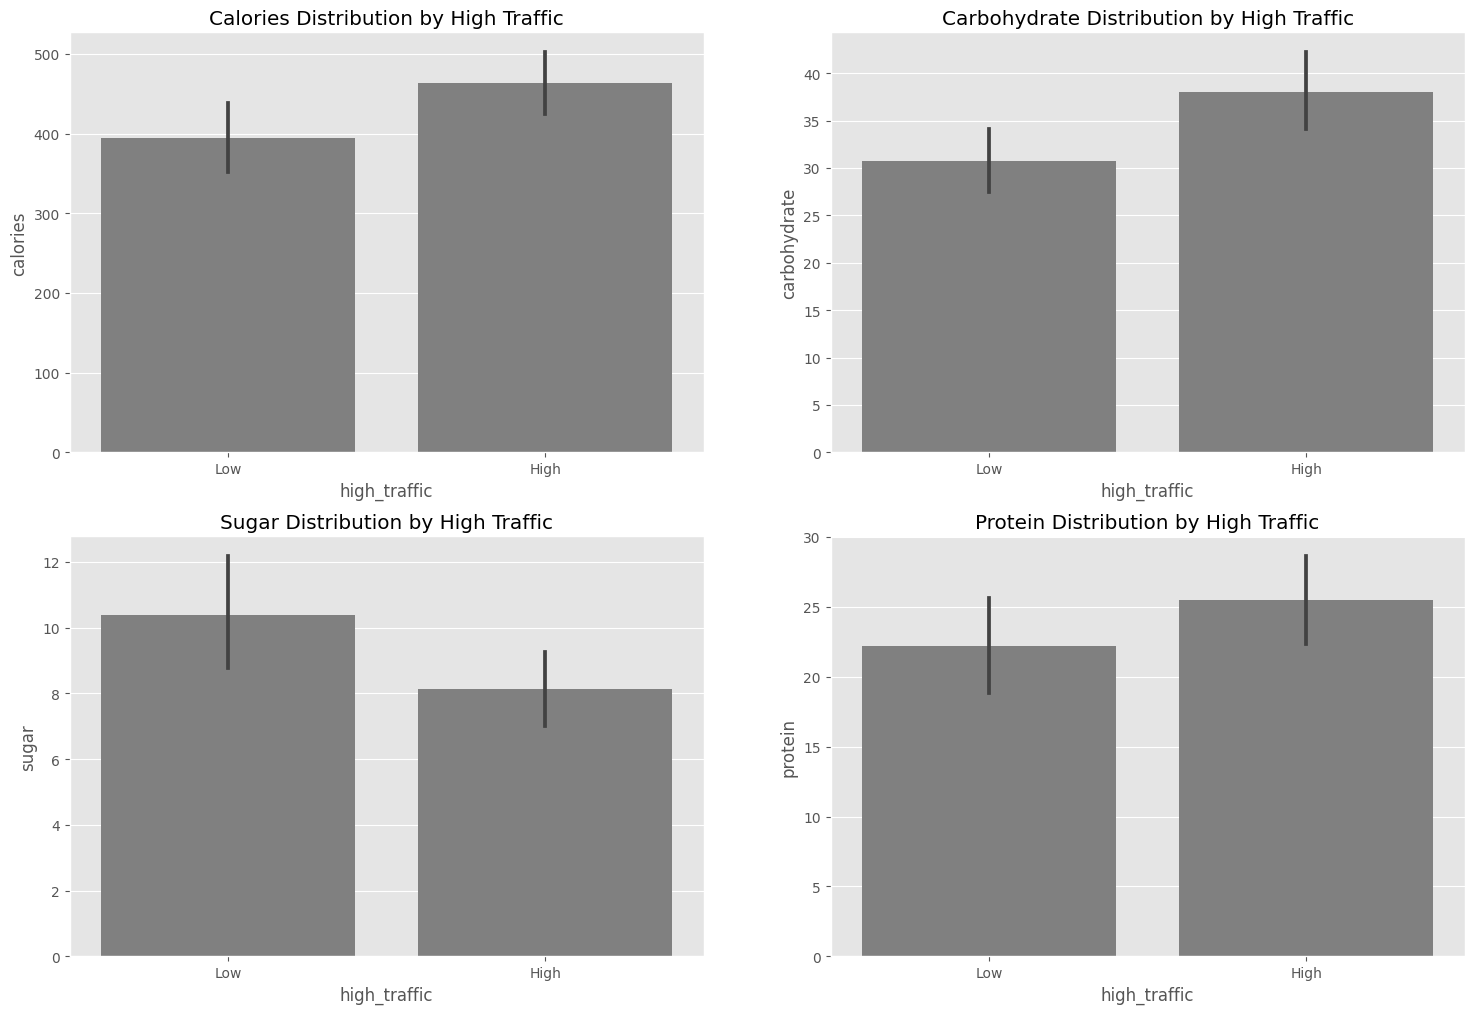

In [166]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
sns.barplot(x=data['high_traffic'], y=data['calories'], color='gray', ax=axes[0, 0]).set(title='Calories Distribution by High Traffic')
sns.barplot(x=data['high_traffic'], y=data['carbohydrate'], color='gray', ax=axes[0, 1]).set(title='Carbohydrate Distribution by High Traffic')
sns.barplot(x=data['high_traffic'], y=data['sugar'], color='gray', ax=axes[1, 0]).set(title='Sugar Distribution by High Traffic')
sns.barplot(x=data['high_traffic'], y=data['protein'], color='gray', ax=axes[1, 1]).set(title='Protein Distribution by High Traffic')
for ax in fig.axes:
    ax.set_xticklabels(['Low', 'High'])
plt.show()